# **Beef and Pork Classification**


## Import Library

In [ ]:
import os
import cv2
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import precision_recall_fscore_support, classification_report

## Dataset Exploration

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("akhirilanwar/datasetdagingsapioplosan")

print("Path to dataset files:", path)

100%|██████████| 4.44G/4.44G [03:33<00:00, 22.3MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/akhirilanwar/datasetdagingsapioplosan/versions/1


In [ ]:
# Path direktori data setelah diunduh
DATA_DIR = os.path.join(path, 'Dataset Daging All Fix')  # Sesuaikan dengan subdirektori aktual
print(f"DATA_DIR: {DATA_DIR}")
print(f"Contents of dataset directory: {os.listdir(DATA_DIR)}")

# Subdirektori untuk setiap kelas
data_dir_beef = os.path.join(DATA_DIR, 'SAPI')
data_dir_pork = os.path.join(DATA_DIR, 'BABI')
data_dir_mixed = os.path.join(DATA_DIR, 'OPLOSAN')

# os.listdir mengembalikan daftar yang berisi semua file di bawah direktori yang diberikan
print(f"Terdapat {len(os.listdir(data_dir_beef))} gambar daging sapi.")
print(f"Terdapat {len(os.listdir(data_dir_pork))} gambar daging babi.")
print(f"Terdapat {len(os.listdir(data_dir_mixed))} gambar daging oplosan.")

DATA_DIR: /root/.cache/kagglehub/datasets/akhirilanwar/datasetdagingsapioplosan/versions/1/Dataset Daging All Fix
Contents of dataset directory: ['BABI', 'OPLOSAN', 'SAPI']
Terdapat 754 gambar daging sapi.
Terdapat 972 gambar daging babi.
Terdapat 206 gambar daging oplosan.


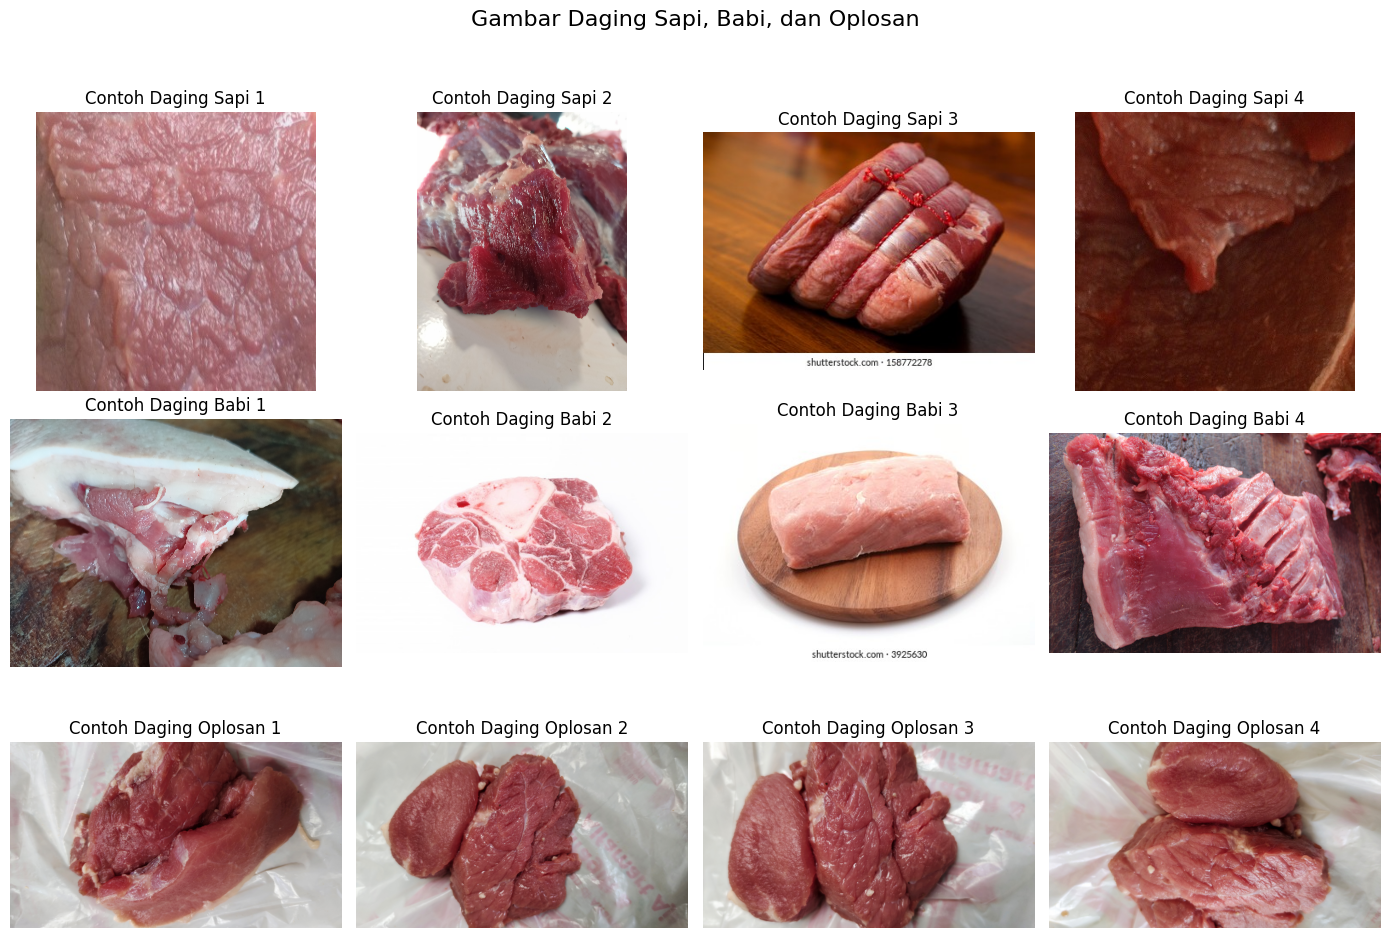

In [ ]:
# Dapatkan nama file untuk gambar daging sapi, babi, dan oplosan
beef_filenames = [os.path.join(data_dir_beef, filename) for filename in os.listdir(data_dir_beef)]
pork_filenames = [os.path.join(data_dir_pork, filename) for filename in os.listdir(data_dir_pork)]
mixed_filenames = [os.path.join(data_dir_mixed, filename) for filename in os.listdir(data_dir_mixed)]

fig, axes = plt.subplots(3, 4, figsize=(14, 10))
fig.suptitle('Gambar Daging Sapi, Babi, dan Oplosan', fontsize=16)

# Plot 4 gambar pertama setiap kelas
for i, beef_image in enumerate(beef_filenames[:4]):
    img = tf.keras.utils.load_img(beef_image)
    axes[0, i].imshow(img)
    axes[0, i].axis('off')  # Hilangkan axis
    axes[0, i].set_title(f'Contoh Daging Sapi {i+1}')

for i, pork_image in enumerate(pork_filenames[:4]):
    img = tf.keras.utils.load_img(pork_image)
    axes[1, i].imshow(img)
    axes[1, i].axis('off')  # Hilangkan axis
    axes[1, i].set_title(f'Contoh Daging Babi {i+1}')

for i, mixed_image in enumerate(mixed_filenames[:4]):
    img = tf.keras.utils.load_img(mixed_image)
    axes[2, i].imshow(img)
    axes[2, i].axis('off')  # Hilangkan axis
    axes[2, i].set_title(f'Contoh Daging Oplosan {i+1}')

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Atur layout agar tidak tumpang tindih
plt.show()

## Pre Processing Train Val Datasets

In [ ]:
def train_val_ds():

    train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
        directory=DATA_DIR,
        image_size=(120,120),
        batch_size=128,
        label_mode='categorical',
        validation_split=0.2,
        subset='both',
        seed=42
    )

    return train_ds, val_ds

In [ ]:
# Membagi dataset
train_ds, val_ds = train_val_ds()

Found 1932 files belonging to 3 classes.
Using 1546 files for training.
Using 386 files for validation.


In [ ]:
# First batch gambar dan label
for images, labels in train_ds.take(1):
	example_batch_images = images
	example_batch_labels = labels

print(f"Maximum pixel value of images: {np.max(example_batch_images)}\n")
print(f"Shape of batch of images: {example_batch_images.shape}")
print(f"Shape of batch of labels: {example_batch_labels.shape}")

Maximum pixel value of images: 255.0

Shape of batch of images: (128, 120, 120, 3)
Shape of batch of labels: (128, 3)


## Augmentasi Model

In [ ]:
def create_augmentation_model():

    augmentation_model = tf.keras.Sequential([
		tf.keras.Input(shape=(120,120,3)),
        tf.keras.layers.RandomFlip('horizontal'),
        tf.keras.layers.RandomTranslation(0.2,0.2, fill_mode='nearest'),
        tf.keras.layers.RandomZoom(0.2, fill_mode='nearest')
    ])

    return augmentation_model

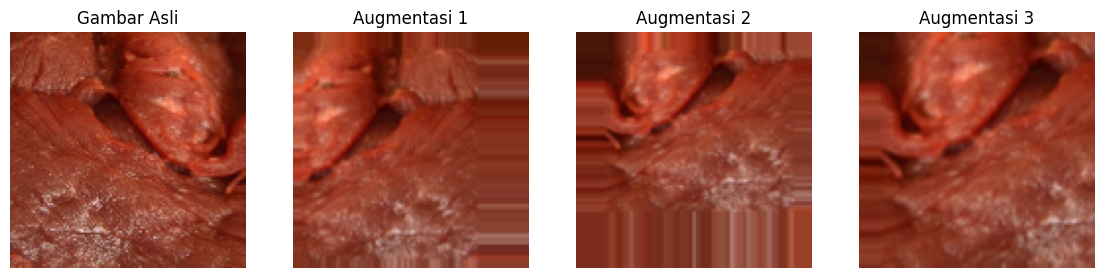

In [ ]:
# Muat model untuk augmentasi
data_augmentor = create_augmentation_model()

# Ambil contoh gambar
sample_image = tf.keras.utils.array_to_img(example_batch_images[0])

images = [sample_image]

# Terapkan augmentasi acak 3 kali
for _ in range(3):
	image_aug = data_augmentor(tf.expand_dims(sample_image, axis=0))
	image_aug = tf.keras.utils.array_to_img(tf.squeeze(image_aug))
	images.append(image_aug)


fig, axs = plt.subplots(1, 4, figsize=(14, 7))
for ax, image, title in zip(axs, images, ['Gambar Asli', 'Augmentasi 1', 'Augmentasi 2', 'Augmentasi 3']):
    ax.imshow(image, cmap='gray')
    ax.set_title(title)
    ax.axis('off')

plt.show()

## Create Model

In [ ]:
def create_model():

    augmentation_layers = create_augmentation_model()

    model = tf.keras.models.Sequential([
		tf.keras.Input(shape=(120, 120, 3)),
        augmentation_layers,
        tf.keras.layers.Rescaling(1./255),
        tf.keras.layers.Conv2D(32, (3,3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dense(3, activation='softmax')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
	)

    return model

In [ ]:
model = create_model()
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)            │ (None, 120, 120, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling (Rescaling)                │ (None, 120, 120, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 118, 118, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 59, 59, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 57, 57, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 26, 26, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 13, 13, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 21632)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       2,769,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,862,659 (10.92 MB)

 Trainable params: 2,862,659 (10.92 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
try:
	model.evaluate(example_batch_images, example_batch_labels, verbose=False)
except:
	print("Your model is not compatible with the dataset you defined earlier. Check that the loss function, last layer and label_mode are compatible with one another.")
else:
	predictions = model.predict(example_batch_images, verbose=False)
	print(f"predictions have shape: {predictions.shape}")

predictions have shape: (128, 3)


## Early Stopping Callback

In [ ]:
# from tensorflow.keras.callbacks import Callback
# class EarlyStoppingCallback(Callback):

#     def on_epoch_end(self, epoch, logs=None):
#         if logs.get('accuracy') >= 0.9 and logs.get('val_accuracy') >= 0.8:
#             self.model.stop_training = True

#             print("\nReached 80% train accuracy and 90% validation accuracy, so cancelling training!")

## Train Model

In [ ]:
# Latih model dan simpan riwayat pelatihan
history = model.fit(
	train_ds,
	epochs=20,
	validation_data=val_ds,
	# callbacks = [EarlyStoppingCallback()]
)

Epoch 1/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 165s 12s/step - accuracy: 0.4189 - loss: 3.4870 - val_accuracy: 0.4663 - val_loss: 3.0958
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 204s 13s/step - accuracy: 0.5620 - loss: 2.9509 - val_accuracy: 0.6503 - val_loss: 2.6267
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 202s 13s/step - accuracy: 0.6006 - loss: 2.5509 - val_accuracy: 0.7021 - val_loss: 2.2165
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 200s 13s/step - accuracy: 0.6255 - loss: 2.2095 - val_accuracy: 0.6632 - val_loss: 1.9420
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 201s 13s/step - accuracy: 0.6497 - loss: 1.9389 - val_accuracy: 0.7124 - val_loss: 1.6469
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 150s 12s/step - accuracy: 0.6821 - loss: 1.7141 - val_accuracy: 0.7798 - val_loss: 1.4357
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 212s 13s/step - accuracy: 0.7047 - loss: 1.5279 - val_accuracy: 0.7358 - val_loss: 1.3901
Epoch 8/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 189s 11s/step - accuracy: 0.6842 - loss: 1.4390 - val_accuracy: 0.

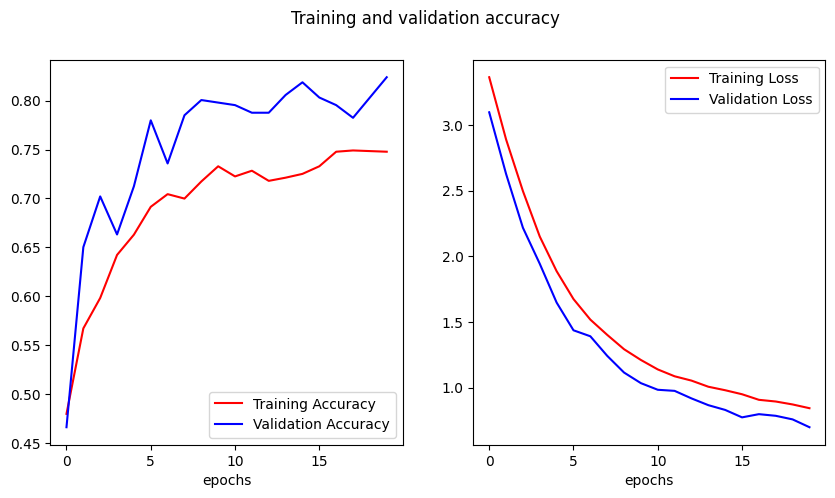

In [ ]:
# Get training and validation accuracies
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Training and validation accuracy')

for i, (data, label) in enumerate(zip([(acc, val_acc), (loss, val_loss)], ["Accuracy", "Loss"])):
    ax[i].plot(epochs, data[0], 'r', label="Training " + label)
    ax[i].plot(epochs, data[1], 'b', label="Validation " + label)
    ax[i].legend()
    ax[i].set_xlabel('epochs')

plt.show()

## Pre Processing Test Datasets

In [ ]:
from sklearn.metrics import classification_report, precision_recall_fscore_support

# Prediksi pada dataset validasi
y_true = []
y_pred = []

# Loop melalui batch dataset validasi
for images, labels in val_ds:
    predictions = model.predict(images)
    y_true.extend(np.argmax(labels, axis=1))  # Konversi one-hot ke label
    y_pred.extend(np.argmax(predictions, axis=1))  # Prediksi label

# Konversi ke numpy array
y_true = np.array(y_true)
y_pred = np.array(y_pred)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


In [ ]:
# Daftar nama kelas
class_names = list(val_ds.class_names)

# Print classification report
report = classification_report(y_true, y_pred, target_names=class_names)
print(report)


              precision    recall  f1-score   support

        BABI       0.85      0.82      0.84       179
     OPLOSAN       0.88      0.86      0.87        42
        SAPI       0.78      0.82      0.80       165

    accuracy                           0.82       386
   macro avg       0.84      0.83      0.83       386
weighted avg       0.83      0.82      0.82       386



In [ ]:
# Hitung precision, recall, dan f1-score
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

Precision: 0.83
Recall: 0.82
F1-Score: 0.82


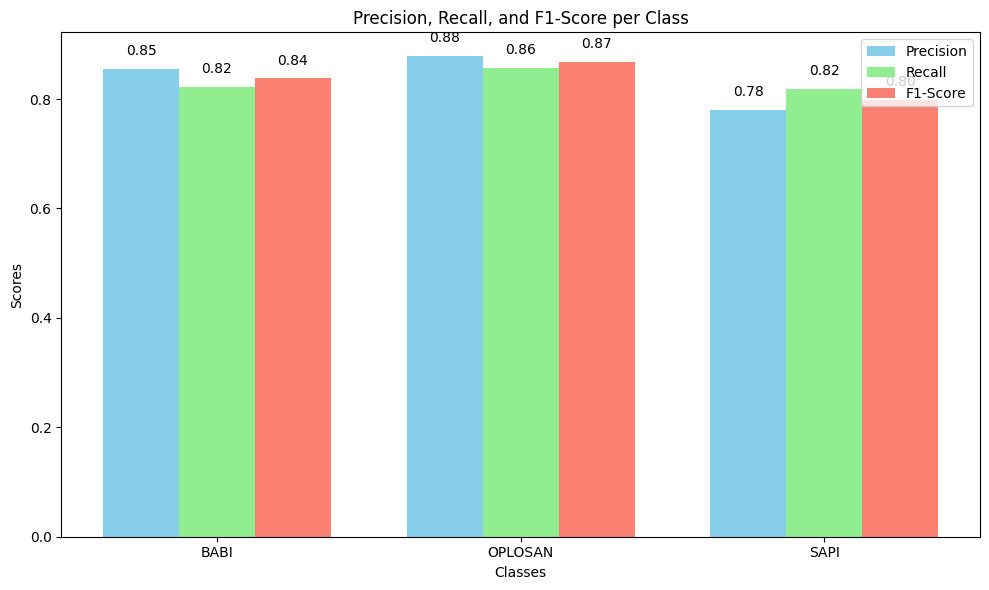

In [ ]:
# Hitung precision, recall, dan F1-score untuk setiap kelas
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average=None)
class_names = val_ds.class_names

# Setup plot
x = np.arange(len(class_names))  # Lokasi kelas di sumbu x
width = 0.25  # Lebar setiap bar
bar_colors = ['skyblue', 'lightgreen', 'salmon']

# Create the bar plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot precision, recall, dan F1-score secara berdekatan
bars_precision = ax.bar(x - width, precision, width, label='Precision', color=bar_colors[0])
bars_recall = ax.bar(x, recall, width, label='Recall', color=bar_colors[1])
bars_f1 = ax.bar(x + width, f1, width, label='F1-Score', color=bar_colors[2])

# Add text labels on top of each bar
for bars, metric_values in zip([bars_precision, bars_recall, bars_f1], [precision, recall, f1]):
    for bar, value in zip(bars, metric_values):
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.02, f'{value:.2f}', ha='center', va='bottom')

# Add labels and title
ax.set_xlabel('Classes')
ax.set_ylabel('Scores')
ax.set_title('Precision, Recall, and F1-Score per Class')
ax.set_xticks(x)
ax.set_xticklabels(class_names)
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()

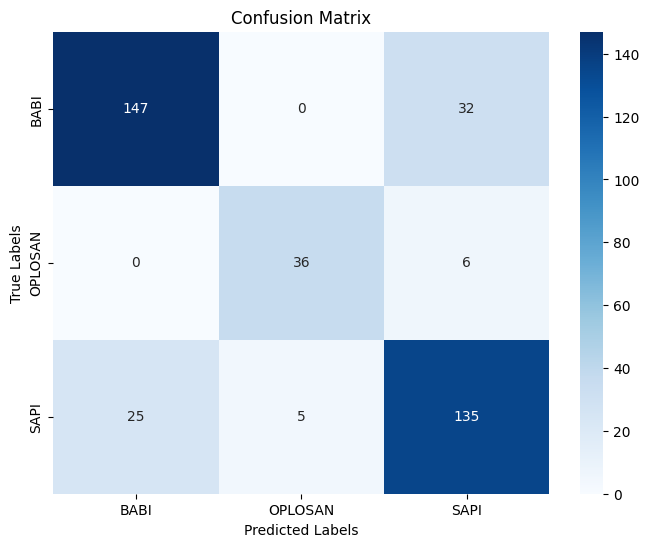

In [ ]:
# Hitung confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=val_ds.class_names, yticklabels=val_ds.class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

## Save Model

In [ ]:
model.save('beef_vs_pork_model.h5')